Coupling map:


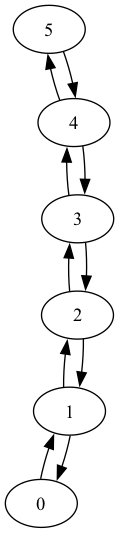

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

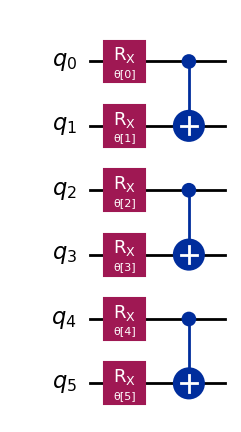

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 4.665466064857704, ParameterVectorElement(θ[1]): 3.4958331672967256, ParameterVectorElement(θ[2]): 1.1607433119572852, ParameterVectorElement(θ[3]): 3.9246618340416872, ParameterVectorElement(θ[4]): 0.8148633976847353, ParameterVectorElement(θ[5]): 6.110646020345377}


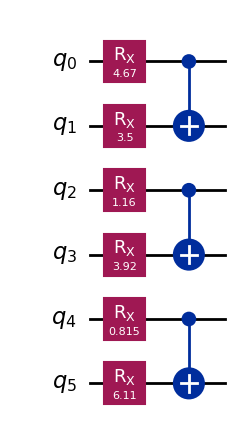

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

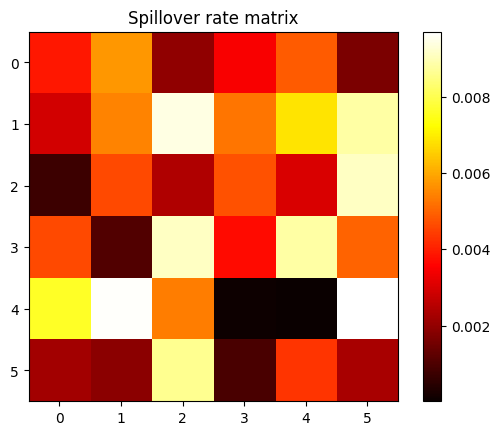

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.05  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.05  # γ_1->2
gamma_matrix[2, 2] = 0.05  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.01 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

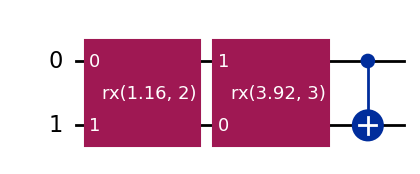

In [5]:
q_eff_0 = int(np.round(0.5 * num_qubits) - 1)
q_eff_1 = q_eff_0 + 1

pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(q_eff_0, q_eff_1),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

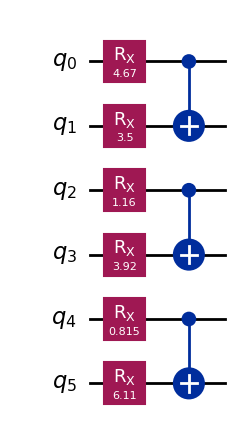

In [6]:
circ = circuit.assign_parameters(param_dict)
circ.draw('mpl')

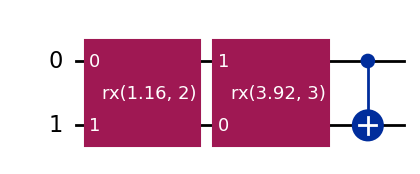

In [7]:
circ_noisy = pm.run(circ)
circ_noisy.draw('mpl')

In [8]:
print(param_dict)

{ParameterVectorElement(θ[0]): 4.665466064857704, ParameterVectorElement(θ[1]): 3.4958331672967256, ParameterVectorElement(θ[2]): 1.1607433119572852, ParameterVectorElement(θ[3]): 3.9246618340416872, ParameterVectorElement(θ[4]): 0.8148633976847353, ParameterVectorElement(θ[5]): 6.110646020345377}


In [9]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(q_eff_0, q_eff_1),
)

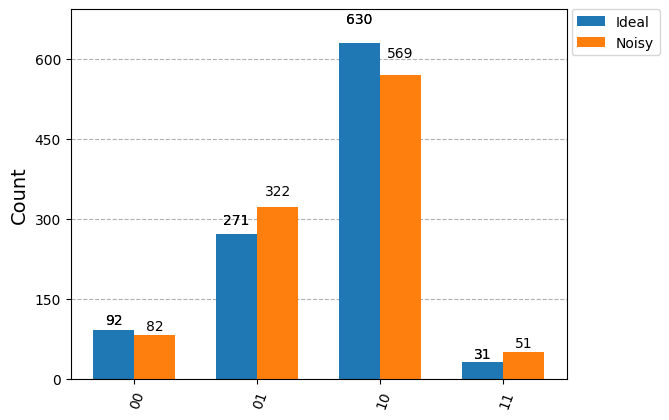

In [10]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [11]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [12]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9921630325101866

In [13]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (q_eff_0, q_eff_1),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=None,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[3, 6, 9, 12],
        n_shots=100,
        sampling_paulis=200,
        c_factor=1,
        seed=seed+6,
    ),
    reward_config="channel",
    env_metadata=env_metadata,
)

In [15]:
print(qc_noisy)

   ┌──────────────┐┌──────────────┐     
0: ┤0             ├┤1             ├──■──
   │  rx(1.16, 2) ││  rx(3.92, 3) │┌─┴─┐
1: ┤1             ├┤0             ├┤ X ├
   └──────────────┘└──────────────┘└───┘


In [16]:
# Constructing context-aware environment
context_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)
rescaled_context_env = RescaleAndClipAction(context_env, -1, 1)

In [17]:
# Testing context_env functionality

obs, info = context_env.reset()
print(f"obs: {obs}")
print(f"info: {info}")
context_env.clear_history()


 Number of repetitions: 3
obs: [0 0]
info: {'reset_stage': True, 'step': 1, 'gate_index': 0, 'truncation_index': 0}


In [18]:
# Testing rescaled_context_env functionality

obs, info = rescaled_context_env.reset()
print(f"obs: {obs}")
print(f"info: {info}")
rescaled_context_env.unwrapped.clear_history()


 Number of repetitions: 9
obs: [0 0]
info: {'reset_stage': True, 'step': 1, 'gate_index': 0, 'truncation_index': 0}


In [19]:
obs, info = context_env.reset() # Obs needs to be rewritten to correspond to circuit phi values
print(f"obs: {obs}")
print(f"info: {info}")
context_env.clear_history()


 Number of repetitions: 3
obs: [0 0]
info: {'reset_stage': True, 'step': 1, 'gate_index': 0, 'truncation_index': 0}


In [20]:
# Testing whole pipeline from the requirements of an update

obs, info = rescaled_context_env.reset() # Obs needs to be rewritten to correspond to circuit phi values
# This obs should also be passed to the policy for action sampling

# Internally Environment Stuff needs to be re-updated with appropriate circuit phis being used


# Sample Action
sample_action = np.zeros(rescaled_context_env.action_space.shape)
batch_action = np.tile(sample_action, (rescaled_context_env.unwrapped.batch_size, 1))
print(batch_action.shape)
print(len(batch_action))

next_obs, reward, terminated, truncated, infos = rescaled_context_env.step(
    batch_action # passing the batch of actions
)
print(f"next obs: {next_obs}")
print(f"reward: {reward}")

rescaled_context_env.unwrapped.clear_history()


 Number of repetitions: 3
(32, 7)
32
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.7078935106711638 Std: 0.001377908419187026
next obs: [0 0]
reward: [1.23555823 1.23155042 1.23039623 1.22165067 1.22949927 1.24477936
 1.23064146 1.23460901 1.23150219 1.23196851 1.23081954 1.22511369
 1.23255635 1.23709886 1.22640962 1.22904584 1.22627438 1.22551848
 1.23191107 1.22959166 1.23364052 1.22660271 1.23025723 1.22865777
 1.22606582 1.2358286  1.23799548 1.22722792 1.2282242  1.22660307
 1.2378143  1.22532372]


In [21]:
# Writing the new environment

from typing import Dict, Optional, Any, Union, List
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from rl_qoc.environment.context_aware_quantum_environment import ObsType
from spillover_effect_on_subsystem import (
    circuit_context,
    noisy_backend,
)

class GeneralContextQuantumEnvironment(ContextAwareQuantumEnvironment):
    """
    A child class of ContextAwareQuantumEnvironment that samples new circuit parameters 
    each time reset is called and updates the environment accordingly.
    """

    def __init__(
        self,
        training_config: QEnvConfig,
        unbound_full_circuit: QuantumCircuit,
        pass_manager: PassManager,
        spillover_rate_matrix: np.ndarray,
        target_subsystem: tuple,
        training_steps_per_gate: Union[List[int], int] = 1500,
        intermediate_rewards: bool = False,
        **context_kwargs,
    ):
        """
        Initialize the dynamic context-aware quantum environment.

        Args:
            training_config: The configuration of the training environment.
            circuit_context: The circuit context with parameters to be sampled.
            training_steps_per_gate: The number of training steps per gate instance.
            intermediate_rewards: Whether to provide intermediate rewards during training.
            param_bounds: Optional dictionary specifying the bounds [low, high] for each parameter name.
                          If None, defaults to [-π, π] for all parameters.
            **context_kwargs: Additional keyword arguments for the parent class.
        """
        self._theta_low = -np.pi
        self._theta_high = +np.pi
        self._unbound_full_circuit = unbound_full_circuit.copy()  # Store the unbound template circuit
        self._pm = pass_manager
        self._param_names = self._unbound_full_circuit.parameters
        example_angles = np.zeros(len(self._param_names)) + 2.2
        self._init_params = {theta: val for theta, val in zip(self._param_names, example_angles)}
        assigned_circuit = self._unbound_full_circuit.assign_parameters(self._init_params, inplace=False)
        self._init_circuit = self._pm.run(assigned_circuit)
        self._spillover_rate_matrix = spillover_rate_matrix
        self._target_subsystem = target_subsystem
        self._training_steps_per_gate = training_steps_per_gate
        self._intermediate_rewards = intermediate_rewards

        super().__init__(
            training_config=training_config,
            circuit_context=self._init_circuit,
            training_steps_per_gate=training_steps_per_gate,
            intermediate_rewards=intermediate_rewards,
            **context_kwargs
        )

        self.observation_space = Box(
            low=self._theta_low * np.ones_like(example_angles), high=self._theta_high * np.ones_like(example_angles), dtype=np.float32
        )

    def _sample_parameters(self) -> Dict[Parameter, float]:
        """
        Sample new values for the circuit parameters within specified bounds.

        Returns:
            A dictionary mapping each parameter to its sampled value.
        """
        param_dict = {}
        self._current_obs = np.random.uniform(self._theta_low, self._theta_high, len(self._param_names))
        for i, param in enumerate(self._param_names):
            param_dict[param] = self._current_obs[i]
        return param_dict

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment by sampling new circuit parameters and updating the context.

        Args:
            seed: Optional seed for reproducibility.
            options: Optional dictionary of reset options.

        Returns:
            A tuple containing the new observation and info dictionary.
        """
        # Set seed for reproducibility if provided
        if seed is not None:
            np.random.seed(seed)

        # Sample new parameters
        self._current_param_values = self._sample_parameters()

        # Create a new circuit context by assigning the sampled parameters
        new_circuit_context = self._unbound_full_circuit.assign_parameters(self._current_param_values, inplace=False)
        new_noisy_circuit = self._pm.run(new_circuit_context)

        # Update the environment with the new circuit context
        self.set_circuit_context(new_noisy_circuit)

        # Update Backend
        new_backend = noisy_backend(
            new_circuit_context,
            self._spillover_rate_matrix,
            self._target_subsystem
        )
        self.backend = new_backend
        print(self.backend)
        # self.backend.backend = new_backend
        # self.backend.parametrized_circuit_kwargs["backend"] = new_backend

        super().__init__(
            training_config=self.config,
            circuit_context=new_noisy_circuit,
            training_steps_per_gate=self._training_steps_per_gate,
            intermediate_rewards=self._intermediate_rewards,
            # **context_kwargs
        )

        # Call the parent reset method to finish resetting the environment
        obs, info = super().reset(seed=seed, options=options)
        
        # Optionally, add the sampled parameter values to the info dict for debugging
        info["sampled_parameters"] = {p.name: v for p, v in self._current_param_values.items()}
        
        return obs, info

    def set_unbound_circuit_context(self, new_context: QuantumCircuit, **kwargs):
        """
        Override to store the original unbound context for sampling purposes.

        Args:
            new_context: The new unbound circuit context.
            **kwargs: Additional keyword arguments.
        """
        self._original_context = new_context.copy()
        super().set_unbound_circuit_context(new_context, **kwargs)
    
    def _get_obs(self):
            """
            Returns:
                A numpy array containing the current parameter values.
            """

            # Combine base observation with parameter values
            return self._current_obs

In [22]:
print(q_env_config.backend_config.backend)

AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(1.16, 2)', 'rx(3.92, 3)']>)


In [23]:
general_env = GeneralContextQuantumEnvironment(
    q_env_config,
    unbound_full_circuit=circuit,  # Pass the circuit already transpiled through custom pass
    pass_manager=pm,
    spillover_rate_matrix=gamma_matrix,
    target_subsystem=(q_eff_0, q_eff_1),
)
rescaled_general_env = RescaleAndClipAction(general_env, -1, 1)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [24]:
print(general_env._training_config)

QEnvConfig(target=GateTargetConfig(physical_qubits=[0, 1], gate=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])), backend_config=QiskitConfig(parametrized_circuit=<function apply_parametrized_circuit at 0x1254b2d40>, backend=AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(1.16, 2)', 'rx(3.92, 3)']>), parametrized_circuit_kwargs={'target': {'gate': 'cnot', 'physical_qubits': [0, 1]}, 'backend': AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(1.16, 2)', 'rx(3.92, 3)']>)}, skip_transpilation=False, pass_manager=None, instruction_durations=None), action_space=Box(-1.0, 1.0, (7,), float32), execution_config=ExecutionConfig(batch_size=32, sampling_paulis=200, n_shots=100, n_reps=[3, 6, 9, 12], c_factor=1, seed=20989, dfe_precision=None, control_flow_enabled=False, n_reps_mode='sequential'), reward_config=ChannelReward(num_eigenstates_per_pauli=1, fiducials_seed=1081554965, input_states_s

In [25]:
# Testing whole pipeline from the requirements of an update

env = rescaled_general_env

obs, info = env.reset() # Obs needs to be rewritten to correspond to circuit phi values
# This obs should also be passed to the policy for action sampling

# Internally Environment Stuff needs to be re-updated with appropriate circuit phis being used


# Sample Action
sample_action = np.zeros(env.action_space.shape)
batch_action = np.tile(sample_action, (env.unwrapped.batch_size, 1))
print(batch_action.shape)
print(len(batch_action))

next_obs, reward, terminated, truncated, infos = env.step(
    batch_action # passing the batch of actions
)
print(f"next obs: {next_obs}")
print(f"reward: {reward}")

env.unwrapped.clear_history()

AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(-0.01, 2)', 'rx(1.36, 3)']>)

 Number of repetitions: 9
(32, 7)
32
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9995640572250529
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9877217773678022 Std: 0.0013489109984890907
next obs: [-0.03954474  0.56447243 -0.00656164  1.35982617  0.59060542  1.8851769 ]
reward: [4.39220885 4.45791567 4.2343775  4.42333323 4.47227541 4.50399514
 4.65882057 4.19589581 4.19955548 4.53637183 4.29062688 4.393602
 4.38710438 4.42491113 4.47540373 4.29837387 4.2542784  4.38313978
 4.49239657 4.3254991  4.43835589 4.4229582  4.29842249 4.39973722
 4.5232578  4.49342486 4.42534675 4.34307702 4.34145569 4.47827044
 4.37854675 4.64882117]


In [26]:
print(np.random.uniform(general_env._theta_low, general_env._theta_high, general_env.observation_space.shape))

[1.65003389 1.11220113]


In [27]:
print(general_env.observation_space.shape)

(2,)


In [28]:
dir(obs)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__o

In [29]:
obs

array([-0.03954474,  0.56447243, -0.00656164,  1.35982617,  0.59060542,
        1.8851769 ])

In [30]:
print(general_env._unbound_circuit_context)

   ┌───────────────┐┌──────────────┐     
0: ┤0              ├┤1             ├──■──
   │  rx(-0.01, 2) ││  rx(1.36, 3) │┌─┴─┐
1: ┤1              ├┤0             ├┤ X ├
   └───────────────┘└──────────────┘└───┘


In [31]:
# Extracting original circuit parameters and shape from env

print(general_env.circuit_context.data)

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.99999462+0.j        , 0.        +0.00328081j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.00328081j, 0.99999462+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99999462+0.j        , 0.        +0.00328081j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.00328081j, 0.99999462+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.77762737+0.j        , 0.        -0.62872544j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.62872544j, 0.77762737+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.      

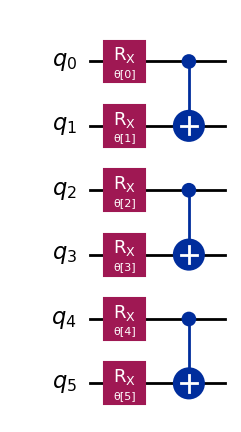

In [32]:
circuit.draw('mpl')

In [33]:
dir(circuit)

['__and__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iand__',
 '__init__',
 '__init_subclass__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_add_qreg',
 '_ancillas',
 '_append',
 '_append_standard_gate',
 '_base_name',
 '_builder_api',
 '_calibrations',
 '_calibrations_prop',
 '_cast',
 '_cbit_argument_conversion',
 '_check_dups',
 '_clbit_indices',
 '_cls_instances',
 '_cls_prefix',
 '_control_flow_scopes',
 '_create_creg',
 '_create_qreg',
 '_current_scope',
 '_data',
 '_duration',
 '_from_circuit_data',
 '_has_calibration_for',
 '_increment_instances',
 '_layout',
 '_metadata',
 '_name_update',
 '_op_start_times',
 '_peek_previ

{ParameterVectorElement(θ[0]): 1.0, ParameterVectorElement(θ[1]): 1.0, ParameterVectorElement(θ[2]): 1.0, ParameterVectorElement(θ[3]): 1.0, ParameterVectorElement(θ[4]): 1.0, ParameterVectorElement(θ[5]): 1.0}


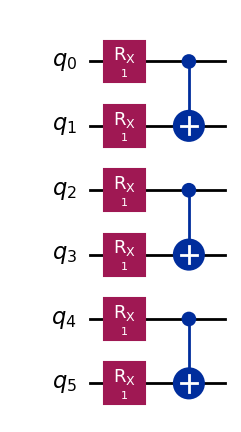

In [34]:
circ_params = circuit.parameters
example_angles = np.ones(len(circ_params))
param_dict = {theta: val for theta, val in zip(circ_params, example_angles)}

print(param_dict)

ones_circuit = circuit.assign_parameters(param_dict, inplace=False)

ones_circuit.draw('mpl')

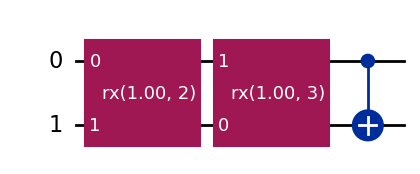

In [35]:
example_noisy_circuit = pm.run(ones_circuit)

example_noisy_circuit.draw('mpl')